Video link here: [YEET](https://youtu.be/_lbslxqEosM)

Workload division list
*   Introduction
    * Writing - Lucas
    * Edits - Anna
*   Equations
    * Writing - Primarily Lucas, some Anna
    * Edits - Both
* Numerical Methods
    * Explanation - Lucas
    * Toy Model+parameter changes - Lucas
    * Sinusoidal Wave - Anna
* Results
    * Simulations 1-4 - honestly a good mix of both
    * Real-world Implications - Lucas
    * Improvements - Anna

# Section 1: Introduction

The 1D Tsunami Wave Propagation on both a global and basin scale is a useful prototype to accurately model tsunami wave simulation. The wave propagation retains outputs for the wave equation method, which implements a spatial discretization, but boundary conditions and initial conditions such as outgoing radiation, external forcing from plate tectonics can greatly alter the outcome of these simulations.
These factors are incredibly important since depending on the strength of these variables, catastrophic damage can occur in a realistic setting.
Other studies, such as Tandel et al. (2022) use the Fractional Reduced Differential Transform Method, which is a non-linear PDE method that uses different coastal slopes and ocean depth in order to model tsunami wave velocity and amplitude.
Tandel's paper builds off of the simpler methods of Kowalik, utilizing the non-linear nature of forcing parameters to build a more accurate model, at the cost of more computation, of course. Therefore, because of the real world implications, this project analyzes Kowalik's models and applied examples from past events, and the analyses drawn can be useful for warning systems and risk management in coastal areas subject to frequent or infrequent tsunami impacts



# Section 2: Equations

To represent how a wave travels in a space and time grid, we use the equations and assumptions as following:

**Governing Equation and Relevant Variables:**

We initially solve the wave equation that we were introduced in class with no external forcing to understand the propagation model:
$$\frac{\partial^2 \zeta}{∂t^2}-c^2\frac{\partial^2 \zeta}{∂x^2}=0$$
In this scenario, the wave equation is derived from the vertical displacement of surface water with respect to wave speed, which is defined as [Eq. II.21]:
$$c=\sqrt{gH}$$
The wave speed is directly proportional to acceleration due to gravity and the undisturbed water depth in a specific area.

We then solve the wave equation that includes external forcing/displacement, substituting in the value of wave speed into the equation as well [Eq. III.3]:
$$\frac{\partial^2 \zeta}{∂t^2}-gH\frac{\partial^2 \zeta}{∂x^2}=\frac{\partial^2 \eta}{∂t^2}$$
The right hand term is defined as the acceleration of vertical displacement. For example, this can be induced from an assumed instantaneous shift in the seafloor bottom since parts of the seafloor rise and subside from plate tectonics in order for earthquakes to occur. With the simple nature of this equation, we also assume a smooth basin floor with no bathymetry, and ignore any other external forces like friction or air resistance.

**Boundary Conditions and Initial Conditions:**

There are two key boundary conditions used in the toy model of the tsunami wave. First, there is zero normal velocity since the model initiates as essentially a block of water, due to the assumption that there is instantaneous acceleration with the disturbance (being an earthquake in the studied example). This initial disturbance sits above sea level, and with the previously defined parameters, propagates through space as a function of gravity and water depth, the inputs of wave speed. Therefore, we have no initial u velocity and $u=0$ when $t=0$. Second, we used a reflective boundary condition, where when the wave reaches the edges of the domain, it deflects off of it, reversing its direction, and travels back towards the center:
$${ζ_{0}^{k+1}}={ζ_{1}^{k+1}}$$
$${ζ_{L}^{k+1}}={ζ_{L-dx}^{k+1}}$$

The wave equation's stability heavily relies on the Courant-Friedrick-Lewy (CFL) stability condition. The courant condition stated in the paper is $q=\frac{cT}{h}$ [Eq. II.48] which has the inequality of $\frac{cT}{h}≤1$. This can also be rewritten to match terms used in the code as:$$\lambda=\frac{c \delta t}{\delta x}≤1$$ The initial value that we used for the CFL will be listed in the initial conditions, but as long as this value was less than or equal to 1, the code did not break due to how the spatial discretization was set up (discussed later in numerical methods + code).

***Table 1***
\begin{array}{|c|c|c|} \hline
Parameter & Variable & Value \\ \hline
Domain\;Length & L & 2e5\;m \\ \hline
Domain\;Spacing & dx & 100\;m \\ \hline
Water\;Depth & H & 3000\; m \\ \hline
Wave\;Height & ζ & 5\;m \\ \hline
Wave\;Length & None & 2e4\;m\\ \hline
Time & t & 600\;s \\ \hline
CFL\;Condition & λ & .99\\ \hline
\end{array}


All of these values will be altered in different runs of the toy model in order to gain sufficient results.

# Section 3: Numerical Methods + Code


As stated previously, the numerical methods used to solve this PDE are essentially the exact same as the methods used to solve the wave equation scheme, except there is an initial wave rather than a flat line. Therefore, we will implement a spatial discretization that models a marching equation for the wave equation.

Starting from the initial wave equation as previously mentioned:
$$\frac{\partial^2 \zeta}{∂t^2}-c^2\frac{\partial^2 \zeta}{∂x^2}=0$$
This equation can be rearranged to set up a discretization (as seen in class):
$$\frac{{ζ_{i}^{k+1}}-2{ζ_{i}^{k}}+{ζ_{i}^{k-1}}}{∂t^2}-c^2\frac{{ζ_{i+1}^{k}}-2{ζ_{i+1}^{k}}+{ζ_{i-1}^{k}}}{∂x^2}=0$$
Then, this equation can be rearranged into a marching equation that also shows the tridiagonal nature of the matrix:
$${{ζ_{i}^{k+1}}}=2(1-\lambda^2){ζ_{i}^{k}}+\lambda^2({{ζ_{i+1}^{k}}+{ζ_{i-1}^{k}}})-{ζ_{i}^{k-1}}$$
As shown through the marching equation, the middle diagonal's central diagonal is based around $2(1-\lambda^2)$ while the off diagonals are based around $\lambda^2$. The external displacement, $\frac{\partial^2 \eta}{∂t^2}$, is implemented through an initial matrix; because the displacement of the toy model is instantaneous, this term does not impact the marching equation.

## Wave Equation Toy Model with Reflective Boundary Conditions

### Scenario 1: Working Toy Model w/ Arbitrary Parameters

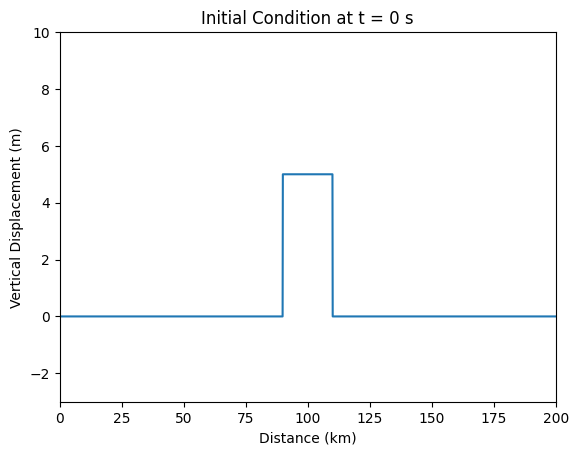

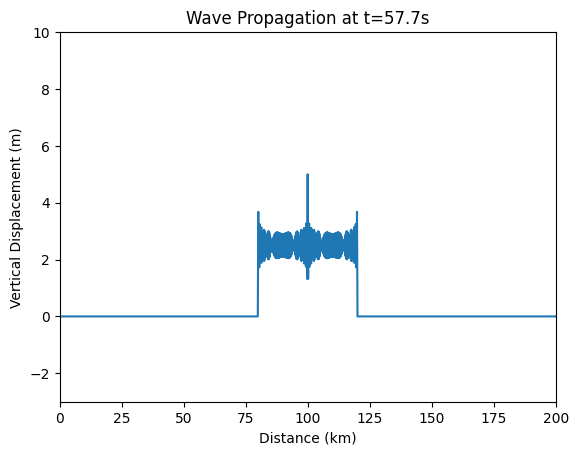

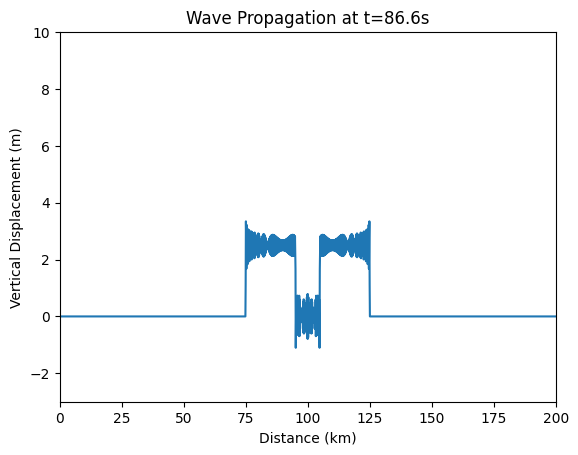

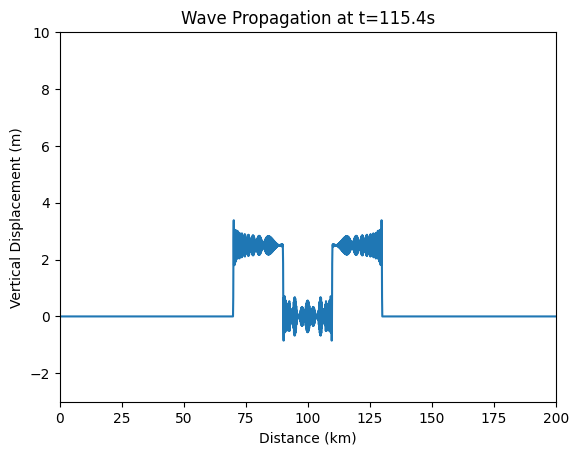

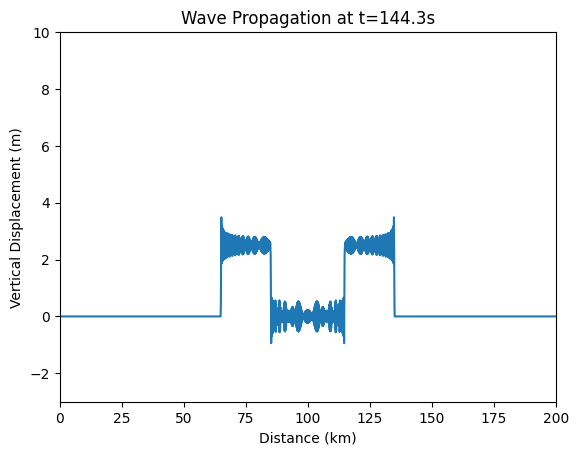

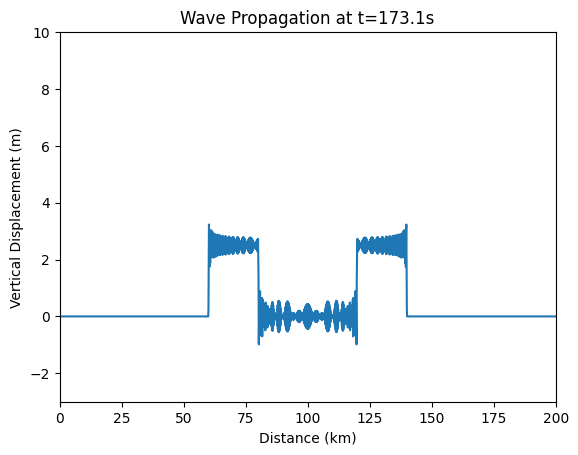

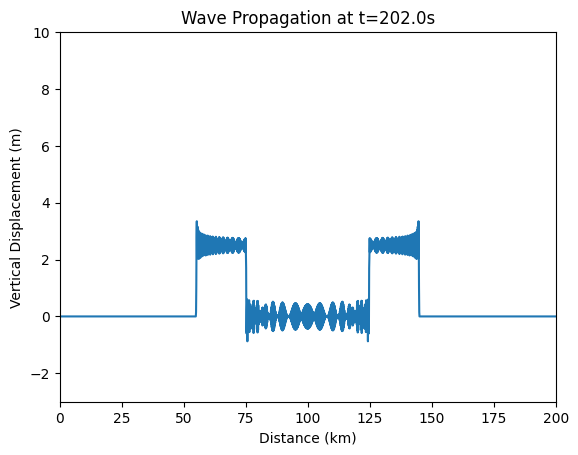

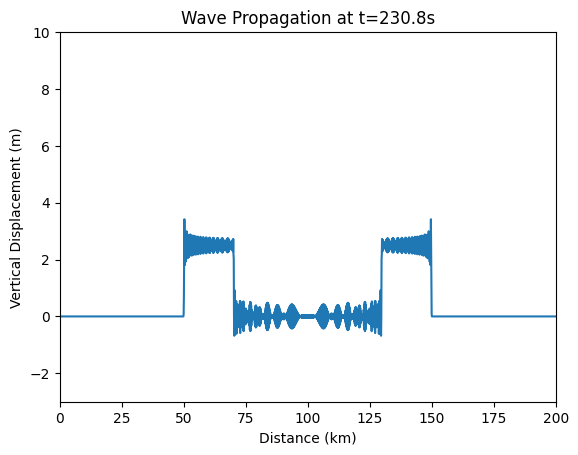

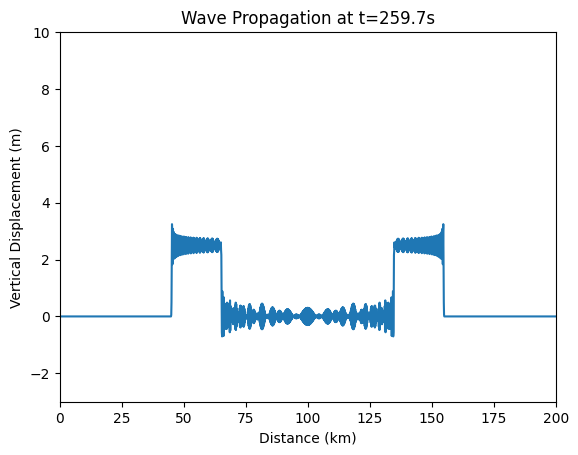

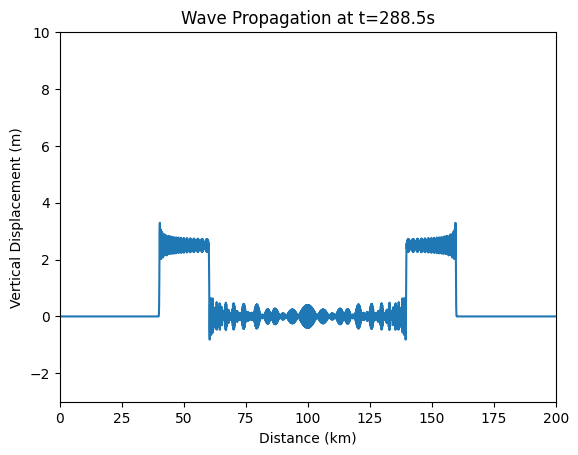

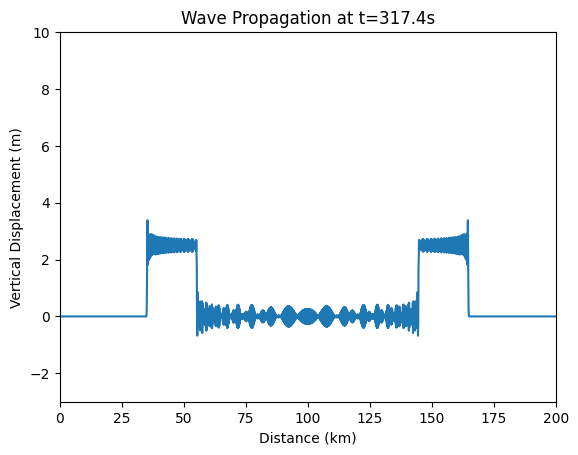

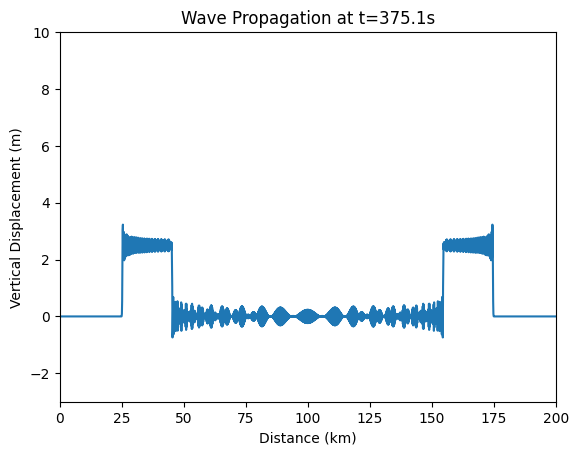

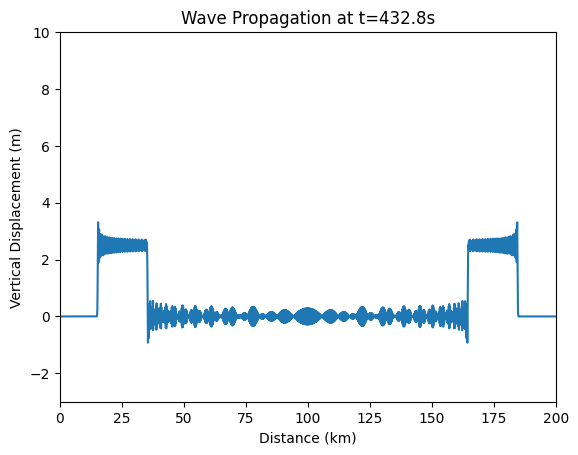

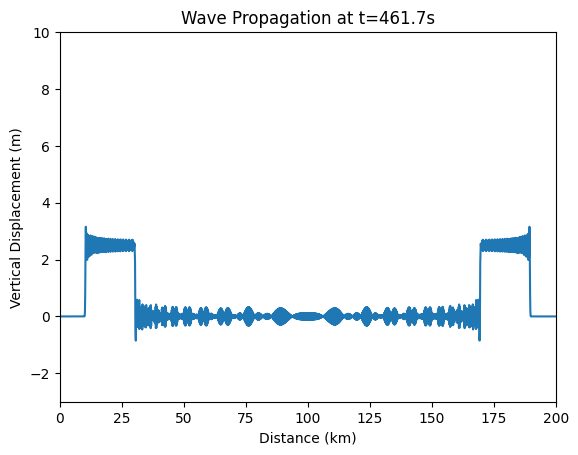

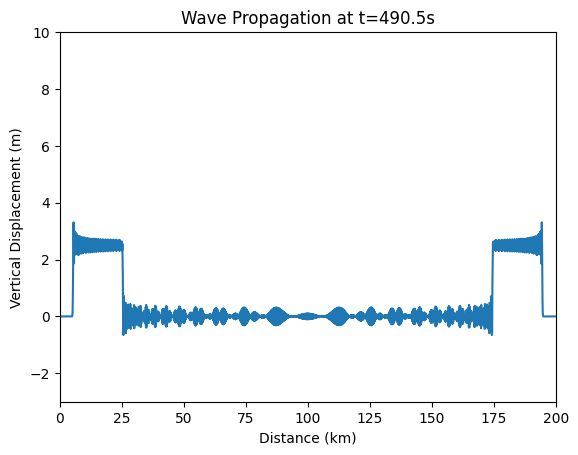

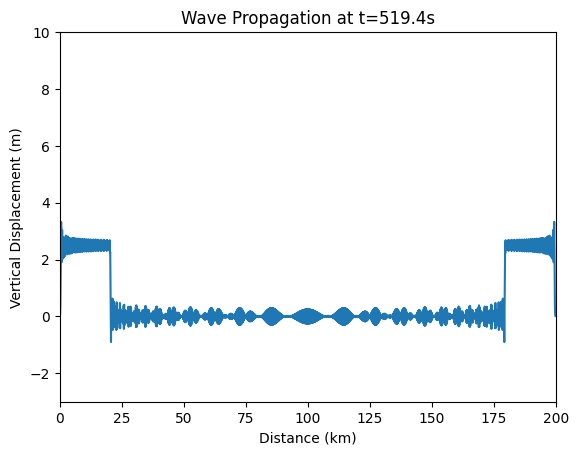

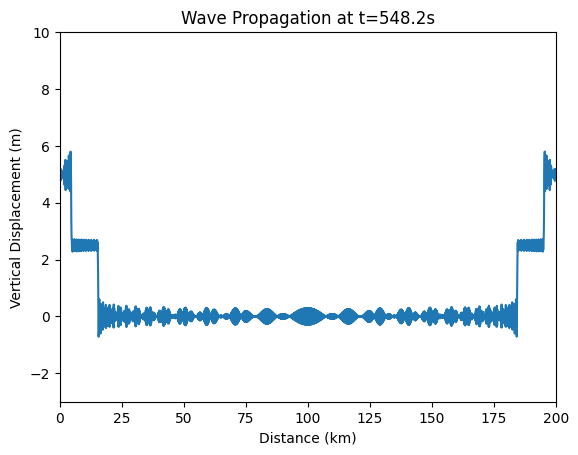

In [1]:
# Import da necessities
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags

# Initial physical parameters
g = 9.81 # Acceleration due to gravity
H = 3000 # Water depth (m)
c = np.sqrt(g*H) # Wave speed (m/s)

# Establishing the domain of this model
L = 2e5 # 200 km domain
dx = 100 # 100 m spacing
x = np.arange(0,L+dx,dx)
nx = len(x)

# Time stepping (with CFL Stability Condition lambda<1)
courant = 0.99 #being equal to 1 caused instability for some reason, so very close to one does the job
dt = courant*dx/c
tf = 600  # Simulate for 10 minutes
nt = int(tf/dt)

# Build tridiagonal sparse matrix M
main_diag = 2*(1-courant)*np.ones(nx)
off_diag  = courant*np.ones(nx)
M = spdiags([off_diag, main_diag, off_diag],[-1, 0, 1],nx, nx).toarray()

# Neumann BC at boundaries
M[0, 0]=2*(1-courant)
M[-1,-1]=2*(1-courant)

# Create an initial wave matrix
wave_init = np.zeros(nx)

# Rectangle wave parameters
wave_length = 20000 # 20 km
wave_height = 5 # 5 m

# Set the rectangular wave condition to the center of the domain
center = L/2
left   = center-wave_length/2
right  = center+wave_length/2
wave_init[(x >= left)&(x <= right)] = wave_height

# Allocate solution array
wave_all = np.zeros((nx, nt+1))
wave_all[:, 0] = wave_init.copy()
wave_all[:, 1] = wave_init.copy()     # zero initial velocity

# Plot the initial wave
plt.figure()
plt.plot(x/1000,wave_all[:,0])
plt.ylim(-3,10)
plt.xlim(0,L/1000)
plt.xlabel("Distance (km)")
plt.ylabel("Vertical Displacement (m)")
plt.title("Initial Condition at t = 0 s")
plt.show()


# Time stepping/updating the wave and plotting
plt.ion()
for n in range(1, nt):
    wave_all[:, n+1] = M @ wave_all[:, n] - wave_all[:, n-1]
    # Reflective Neumann boundaries
    wave_all[0, n+1]  = wave_all[1, n+1]
    wave_all[-1,n+1]  = wave_all[-2,n+1]

    if n % 50 == 0:
        plt.clf()
        plt.plot(x/1000, wave_all[:, n+1])
        plt.ylim(-3,10)
        plt.xlim(0,L/1000)
        plt.xlabel("Distance (km)")
        plt.ylabel("Vertical Displacement (m)")
        plt.title(f"Wave Propagation at t={n*dt:.1f}s")
        plt.pause(0.01)

plt.ioff()
plt.show()


### Scenario 2: Changing spatial grid step

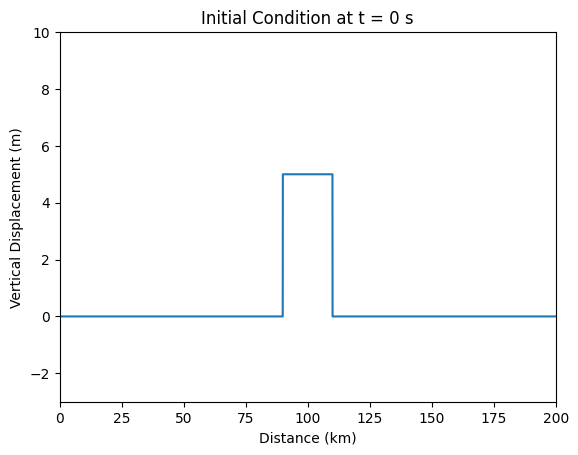

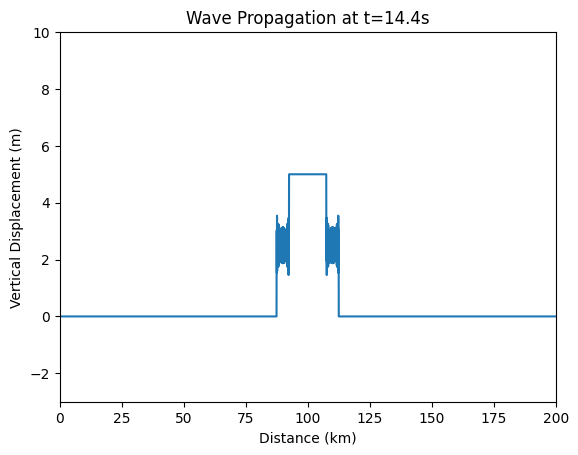

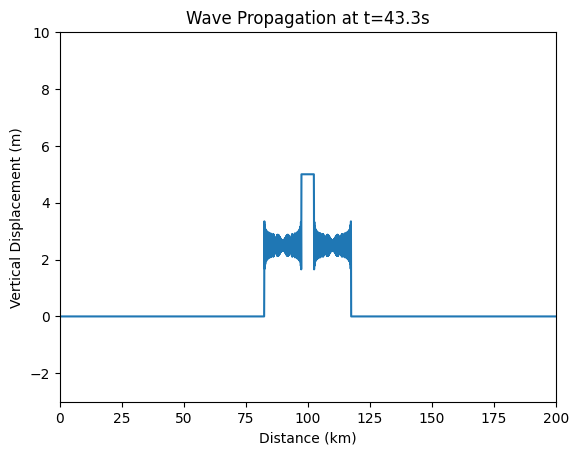

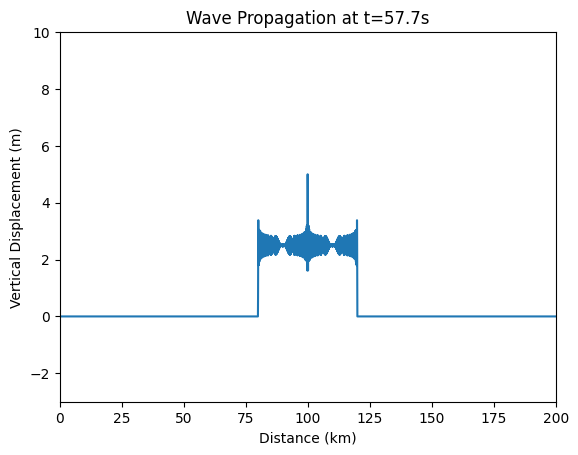

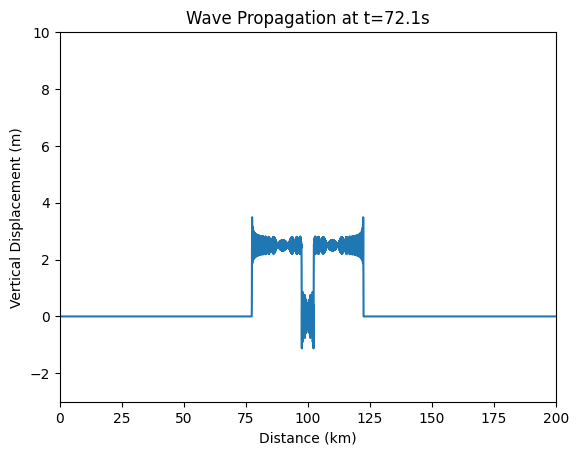

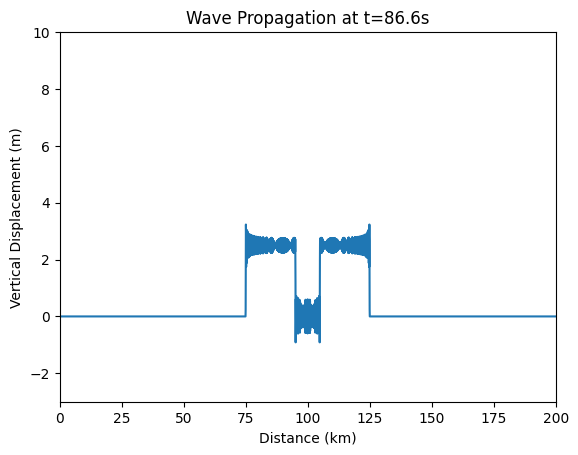

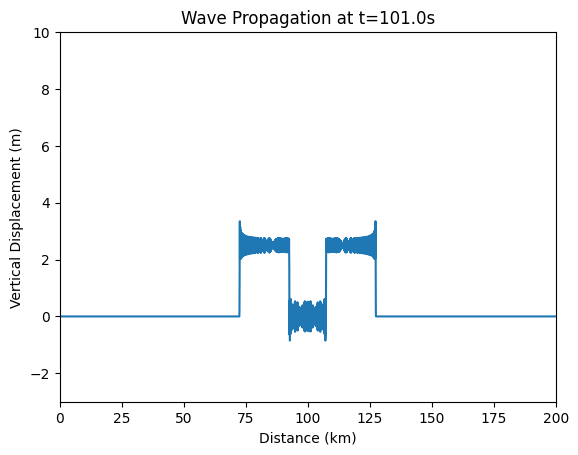

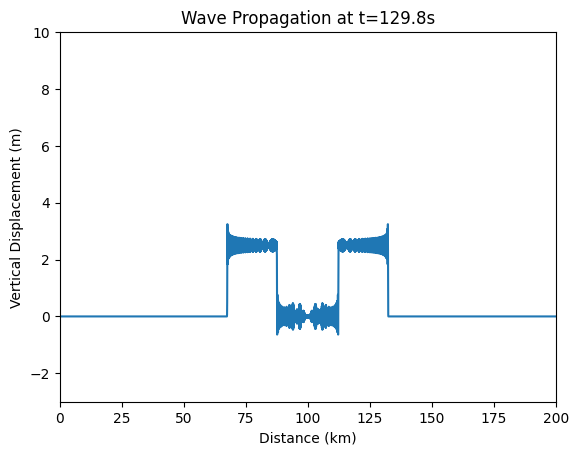

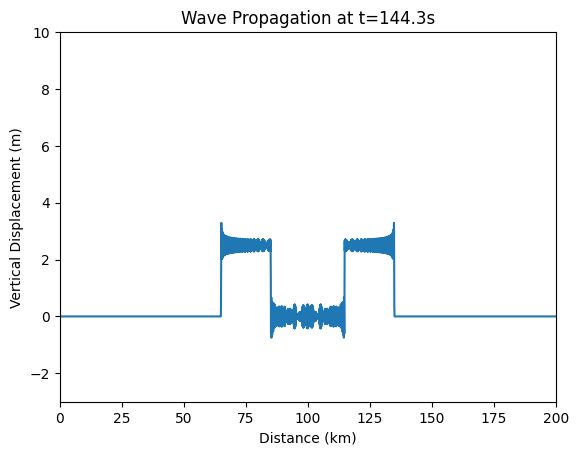

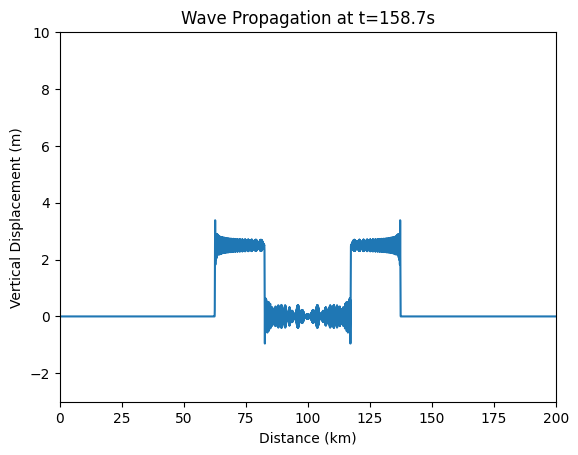

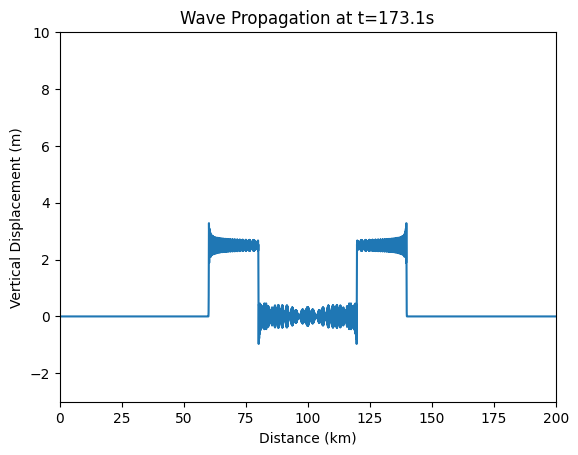

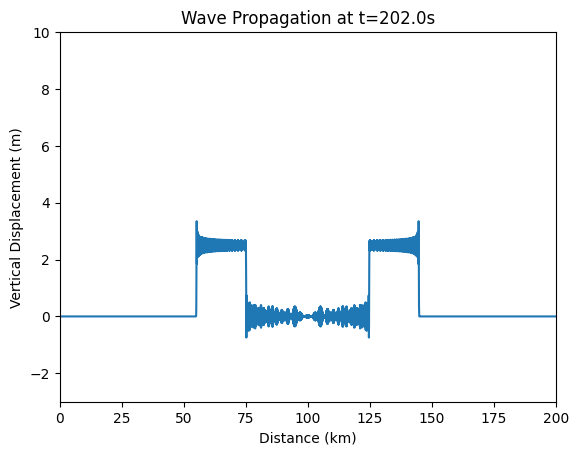

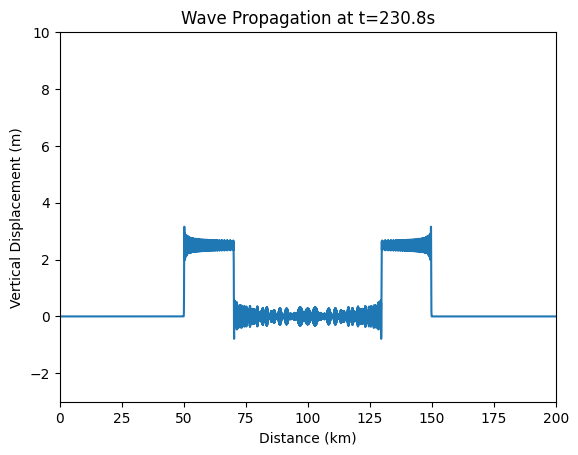

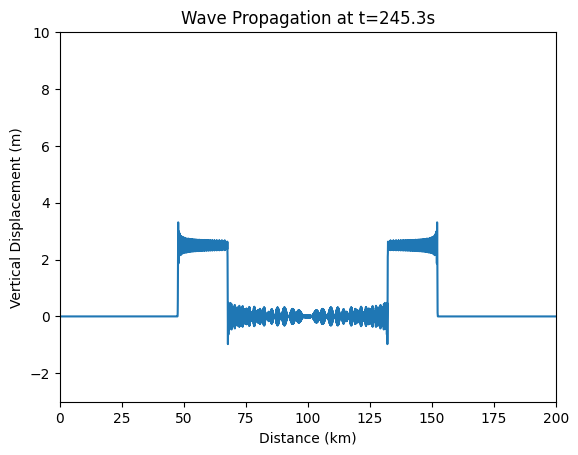

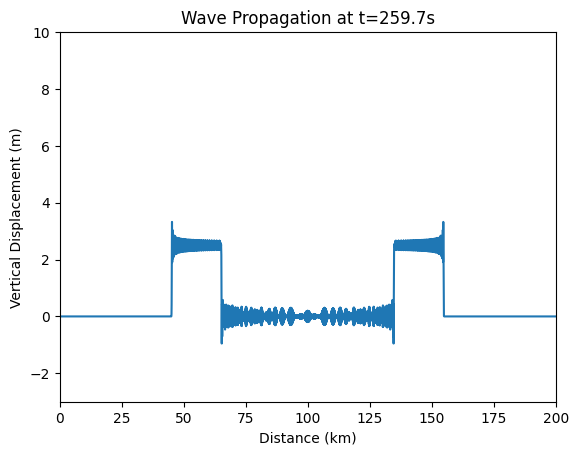

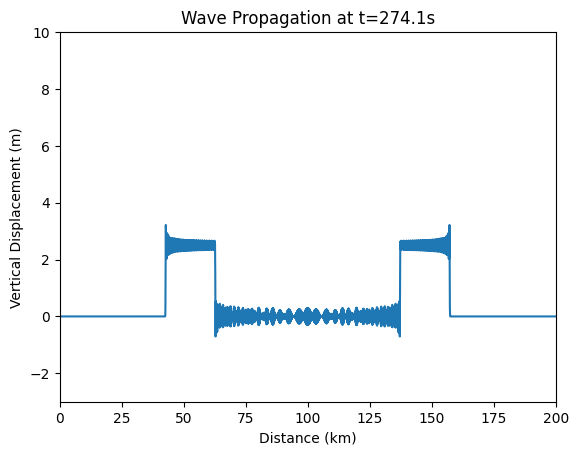

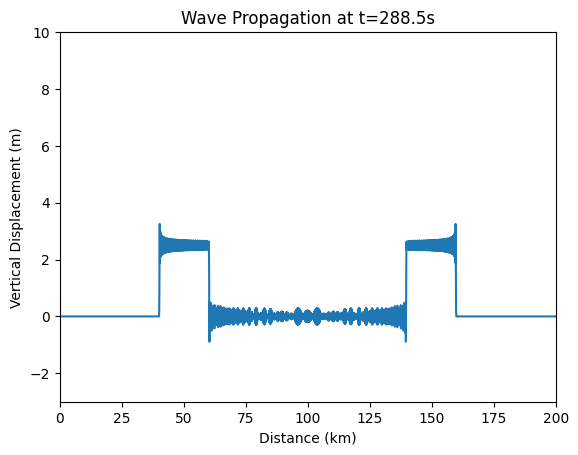

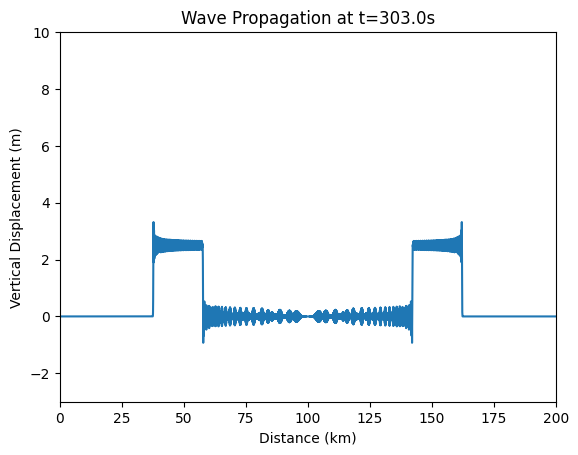

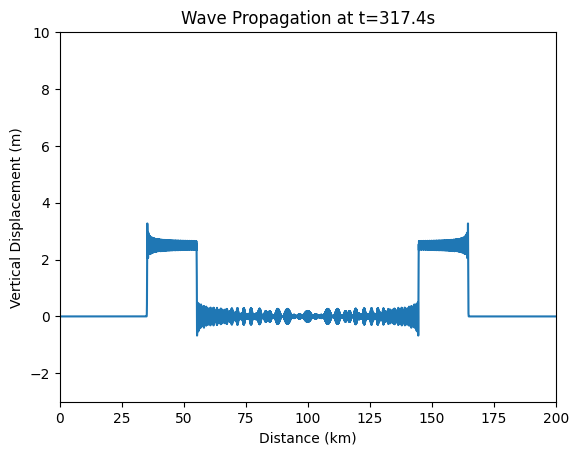

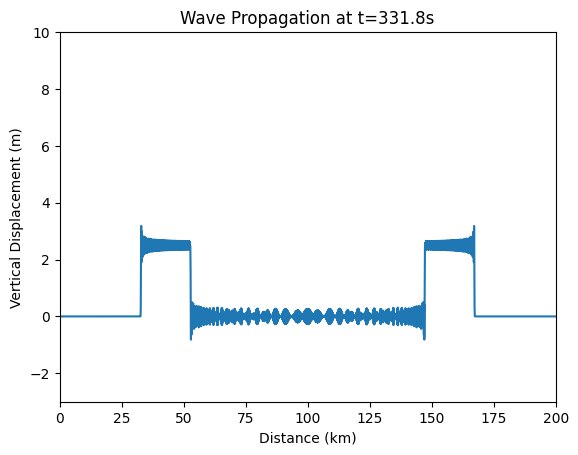

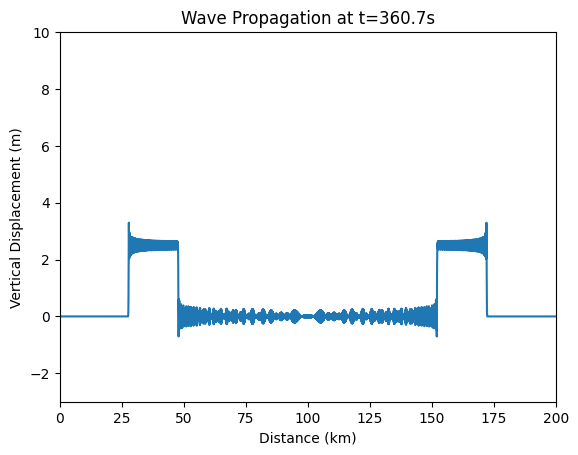

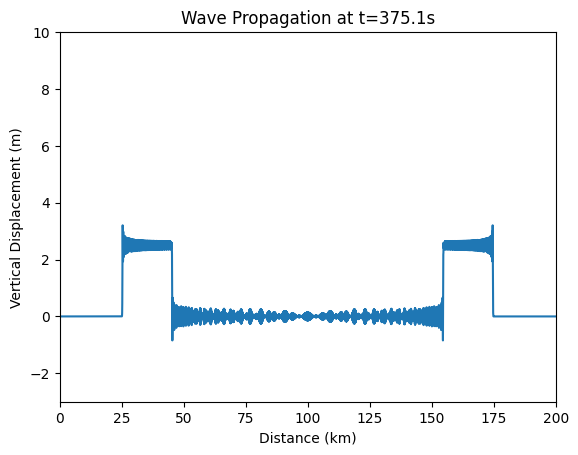

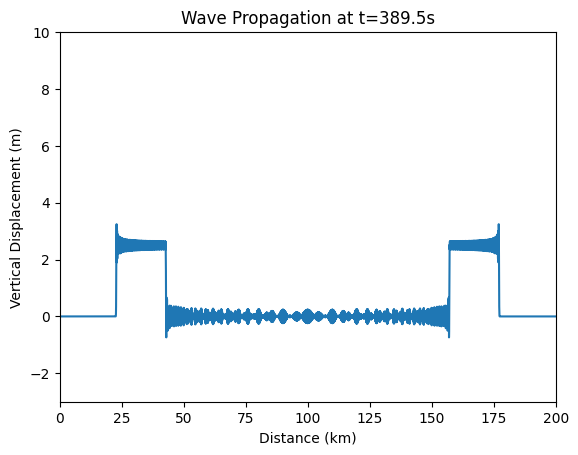

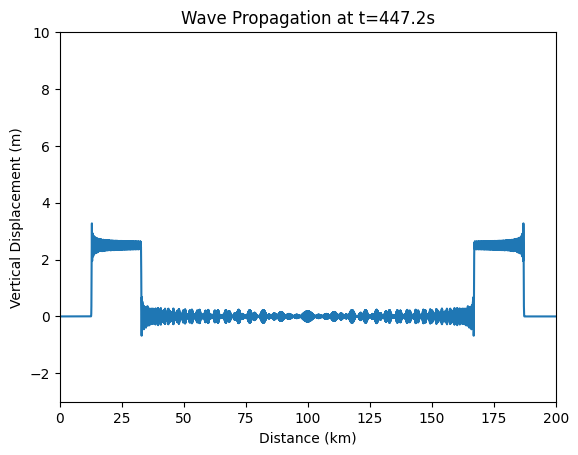

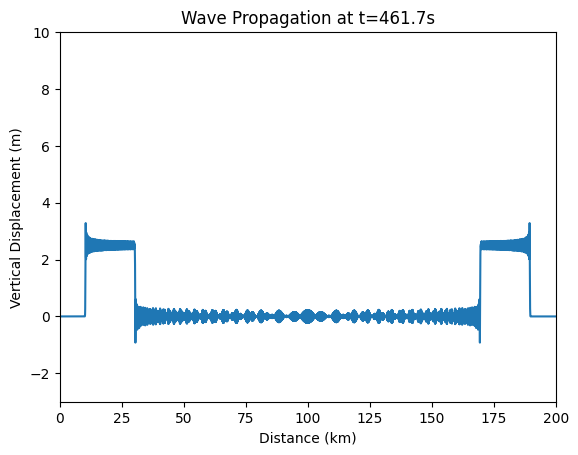

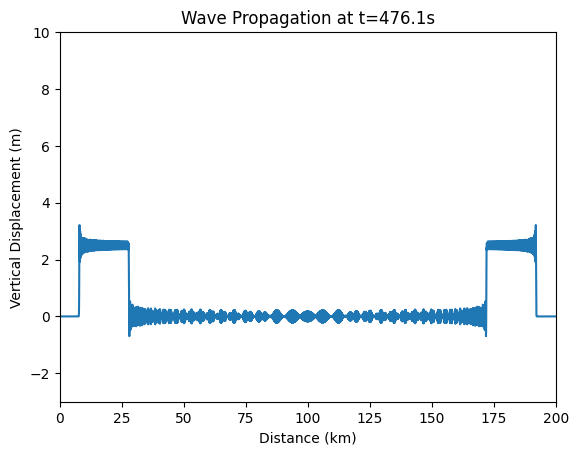

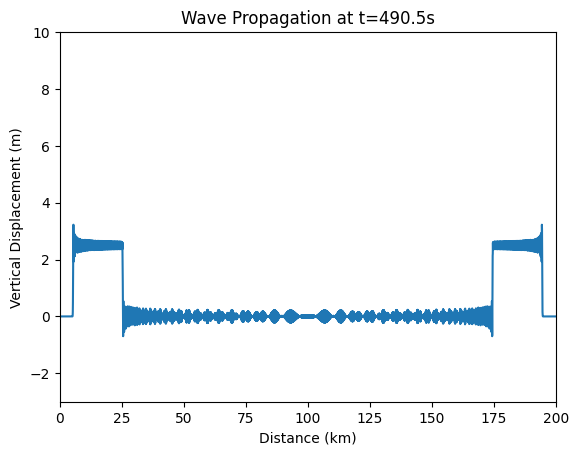

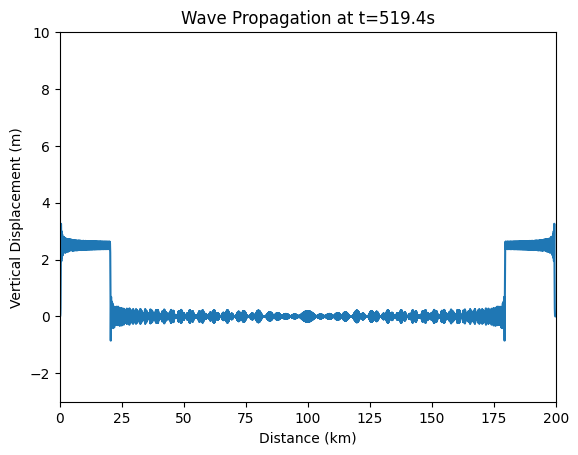

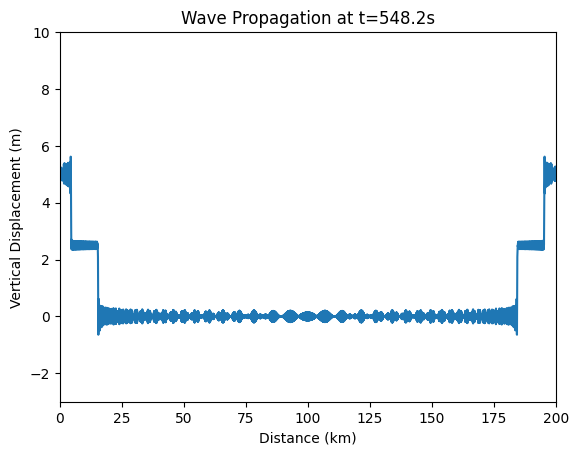

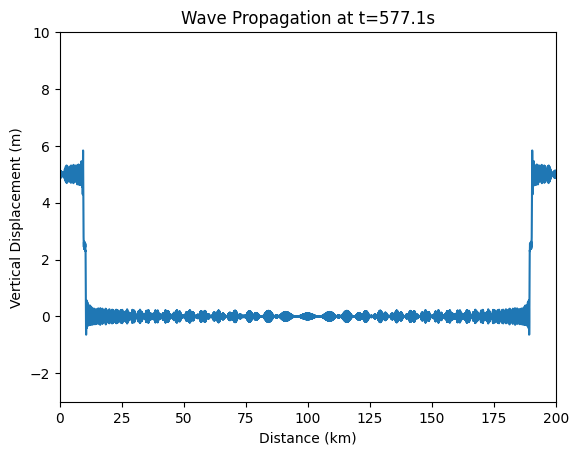

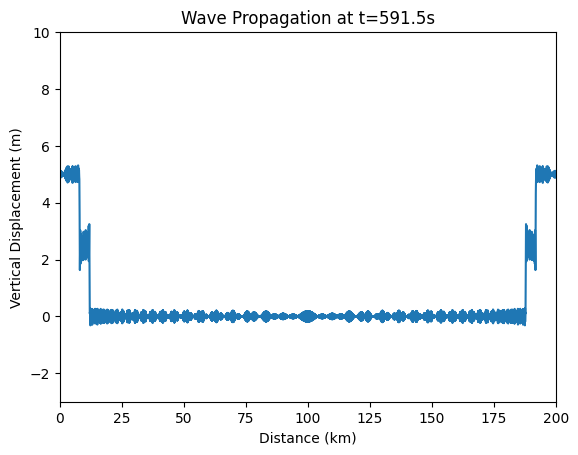

In [2]:
# Initial differently scaled parameters
g = 9.81 # Acceleration due to gravity
H = 3000 # Water depth (m)
c = np.sqrt(g*H) # Wave speed (m/s)

# Establishing the domain of this model
L = 2e5 # 200 km domain
dx = 50 # 50 m spacing
x = np.arange(0,L+dx,dx)
nx = len(x)

# Time stepping (with CFL Stability Condition lambda<1)
courant = 0.99
dt = courant*dx/c
tf = 600  # Simulate for 10 minutes
nt = int(tf/dt)

# Build tridiagonal sparse matrix M
main_diag = 2*(1-courant)*np.ones(nx)
off_diag  = courant*np.ones(nx)
M = spdiags([off_diag, main_diag, off_diag],[-1, 0, 1],nx, nx).toarray()

# Neumann BC at boundaries
M[0, 0]=2*(1-courant)
M[-1,-1]=2*(1-courant)

# Create an initial wave matrix
wave_init = np.zeros(nx)

# Rectangle wave parameters
wave_length = 20000 # 20 km
wave_height = 5 # 5 m

# Set the rectangular wave condition to the center of the domain
center = L/2
left   = center-wave_length/2
right  = center+wave_length/2
wave_init[(x >= left)&(x <= right)] = wave_height

# Allocate solution array
wave_all = np.zeros((nx, nt+1))
wave_all[:, 0] = wave_init.copy()
wave_all[:, 1] = wave_init.copy()     # zero initial velocity

# Plot the initial wave
plt.figure()
plt.plot(x/1000,wave_all[:,0])
plt.ylim(-3,10)
plt.xlim(0,L/1000)
plt.xlabel("Distance (km)")
plt.ylabel("Vertical Displacement (m)")
plt.title("Initial Condition at t = 0 s")
plt.show()


# Time stepping/updating the wave and plotting
plt.ion()
for n in range(1, nt):
    wave_all[:, n+1] = M @ wave_all[:, n] - wave_all[:, n-1]
    # Reflective Neumann boundaries
    wave_all[0, n+1]  = wave_all[1, n+1]
    wave_all[-1,n+1]  = wave_all[-2,n+1]

    if n % 50 == 0:
        plt.clf()
        plt.plot(x/1000, wave_all[:, n+1])
        plt.ylim(-3,10)
        plt.xlim(0,L/1000)
        plt.xlabel("Distance (km)")
        plt.ylabel("Vertical Displacement (m)")
        plt.title(f"Wave Propagation at t={n*dt:.1f}s")
        plt.pause(0.01)

plt.ioff()
plt.show()

### Scenario 3: Changing water depth scale

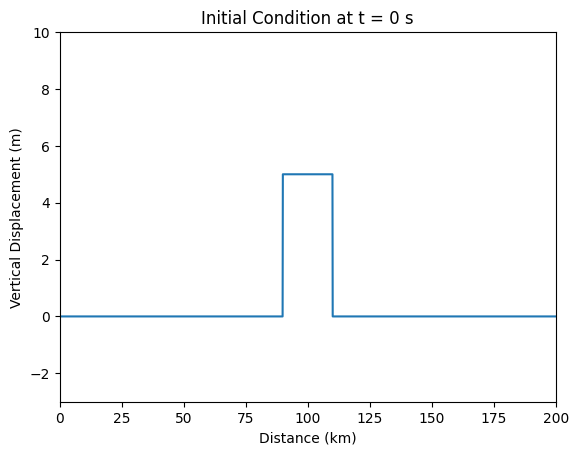

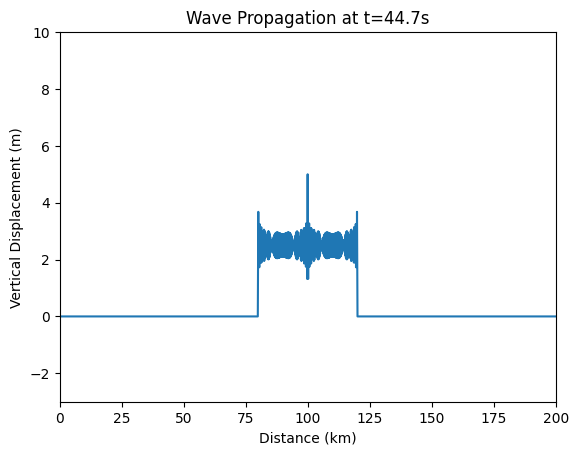

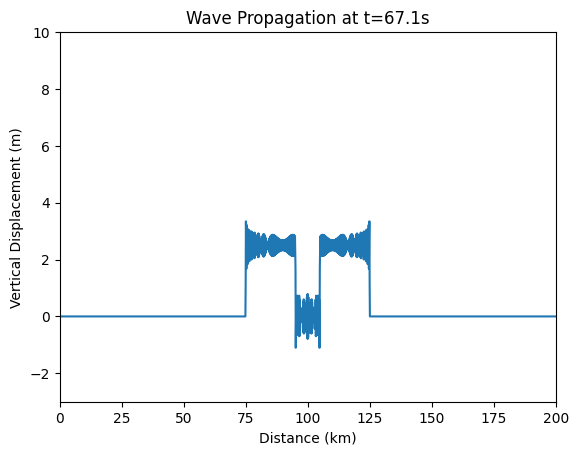

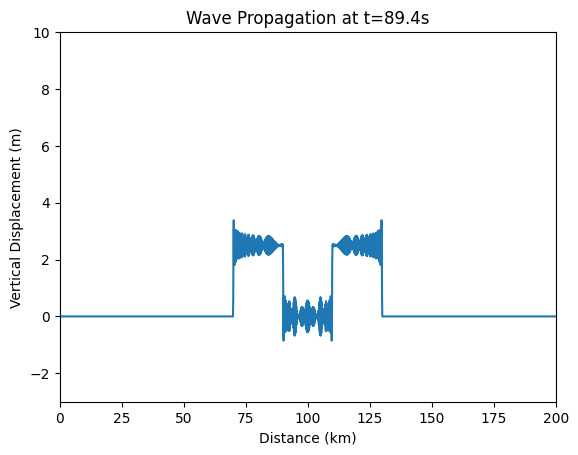

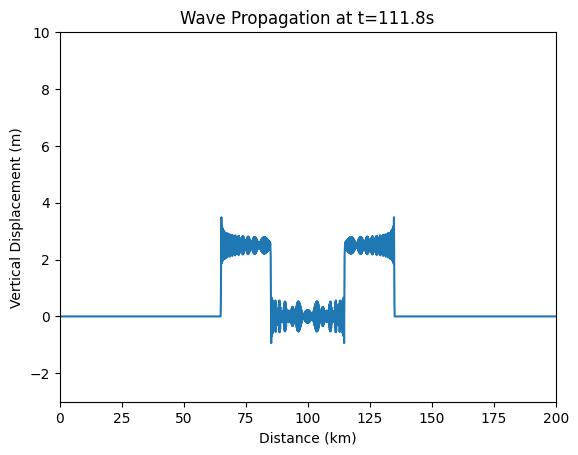

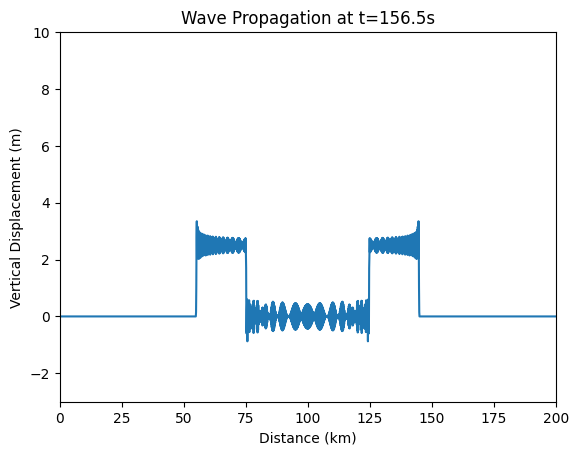

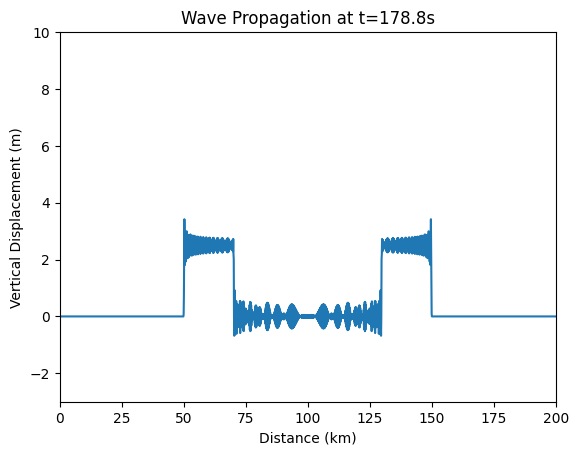

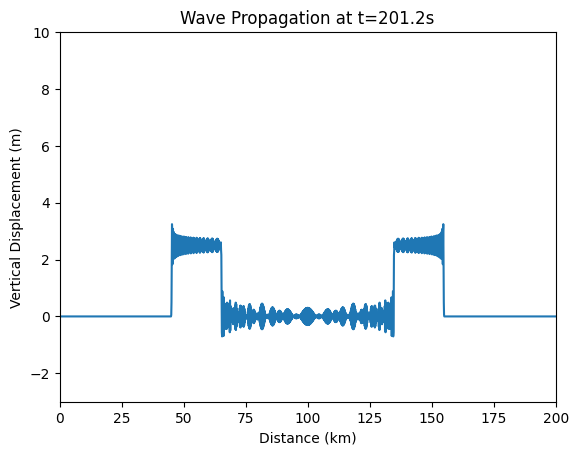

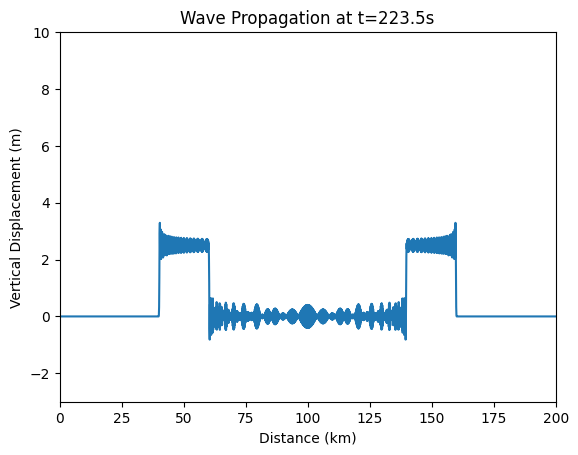

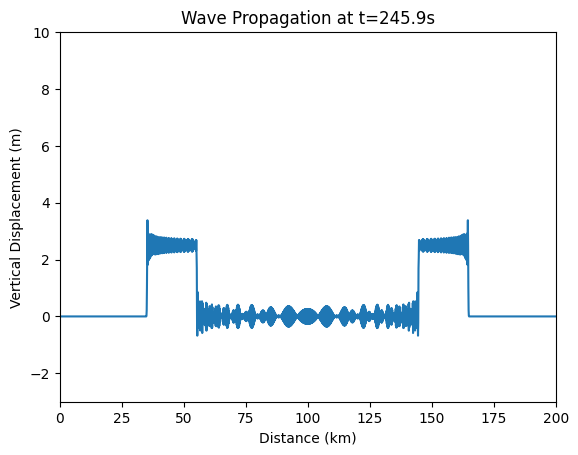

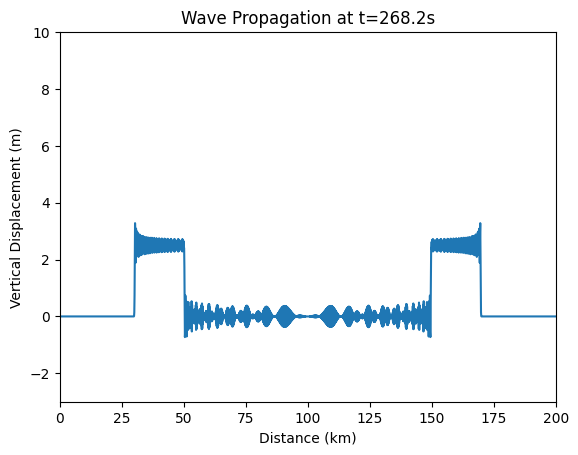

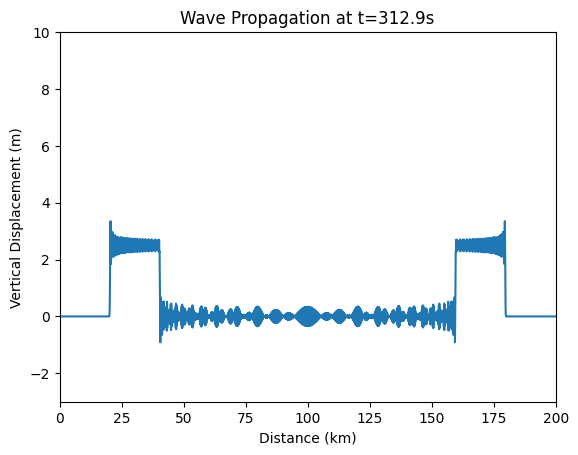

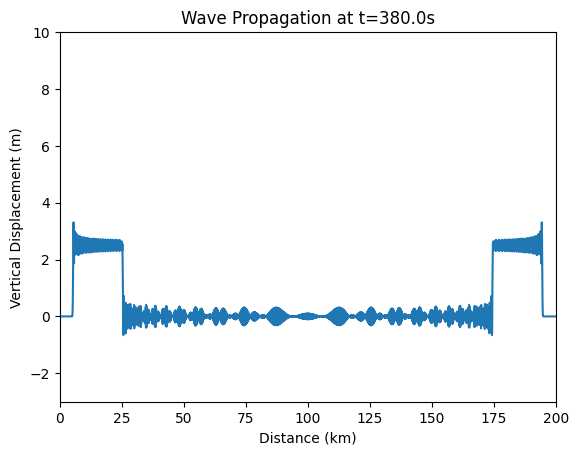

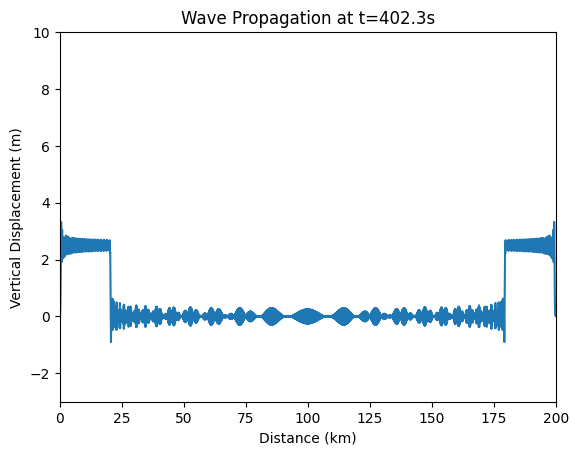

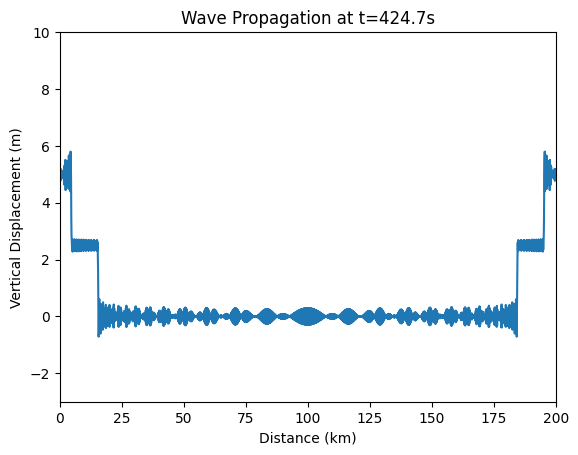

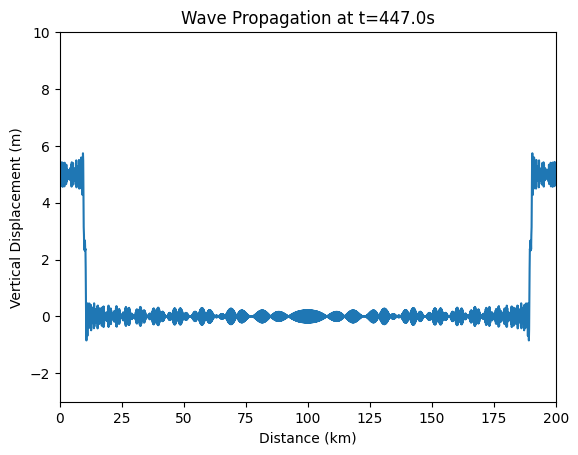

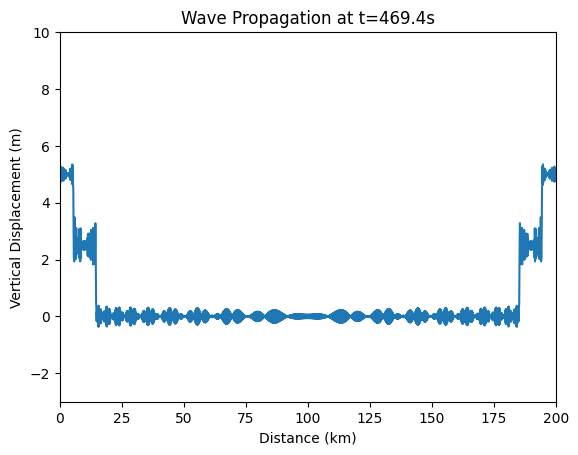

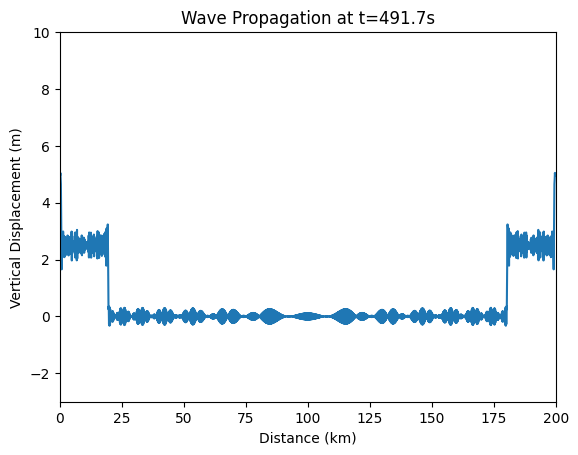

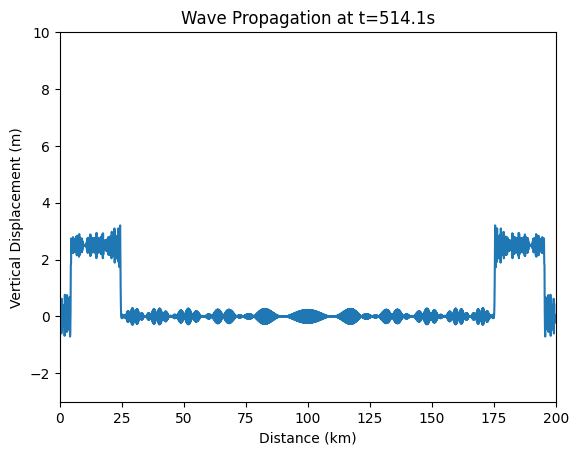

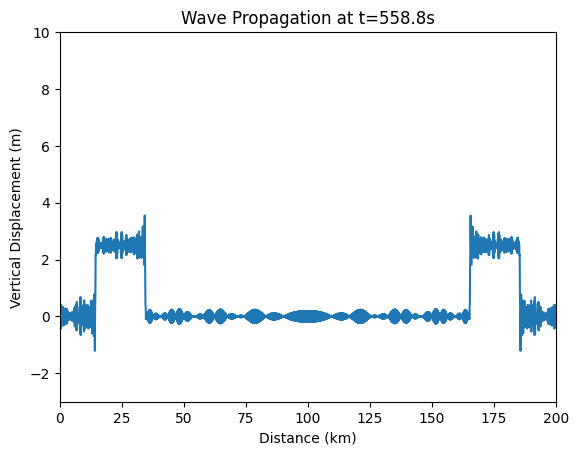

In [3]:
# Initial differently scaled parameters
g = 9.81 # Acceleration due to gravity
H = 5000 # Water depth (m)
c = np.sqrt(g*H) # Wave speed (m/s)

# Establishing the domain of this model
L = 2e5 # 200 km domain
dx = 100 # 100 m spacing
x = np.arange(0,L+dx,dx)
nx = len(x)

# Time stepping (with CFL Stability Condition lambda<1)
courant = 0.99
dt = courant*dx/c
tf = 600  # Simulate for 10 minutes
nt = int(tf/dt)

# Build tridiagonal sparse matrix M
main_diag = 2*(1-courant)*np.ones(nx)
off_diag  = courant*np.ones(nx)
M = spdiags([off_diag, main_diag, off_diag],[-1, 0, 1],nx, nx).toarray()

# Neumann BC at boundaries
M[0, 0]=2*(1-courant)
M[-1,-1]=2*(1-courant)

# Create an initial wave matrix
wave_init = np.zeros(nx)

# Rectangle wave parameters
wave_length = 20000 # 20 km
wave_height = 5 # 5 m

# Set the rectangular wave condition to the center of the domain
center = L/2
left   = center-wave_length/2
right  = center+wave_length/2
wave_init[(x >= left)&(x <= right)] = wave_height

# Allocate solution array
wave_all = np.zeros((nx, nt+1))
wave_all[:, 0] = wave_init.copy()
wave_all[:, 1] = wave_init.copy()     # zero initial velocity

# Plot the initial wave
plt.figure()
plt.plot(x/1000,wave_all[:,0])
plt.ylim(-3,10)
plt.xlim(0,L/1000)
plt.xlabel("Distance (km)")
plt.ylabel("Vertical Displacement (m)")
plt.title("Initial Condition at t = 0 s")
plt.show()


# Time stepping/updating the wave and plotting
plt.ion()
for n in range(1, nt):
    wave_all[:, n+1] = M @ wave_all[:, n] - wave_all[:, n-1]
    # Reflective Neumann boundaries
    wave_all[0, n+1]  = wave_all[1, n+1]
    wave_all[-1,n+1]  = wave_all[-2,n+1]

    if n % 50 == 0:
        plt.clf()
        plt.plot(x/1000, wave_all[:, n+1])
        plt.ylim(-3,10)
        plt.xlim(0,L/1000)
        plt.xlabel("Distance (km)")
        plt.ylabel("Vertical Displacement (m)")
        plt.title(f"Wave Propagation at t={n*dt:.1f}s")
        plt.pause(0.01)

plt.ioff()
plt.show()

### Scenario 4: Sinusoidal wave shape

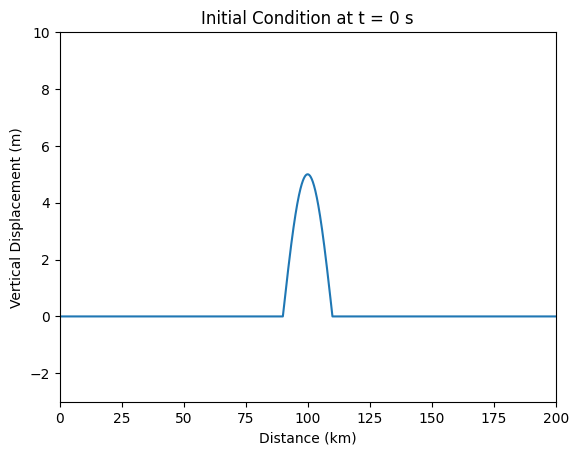

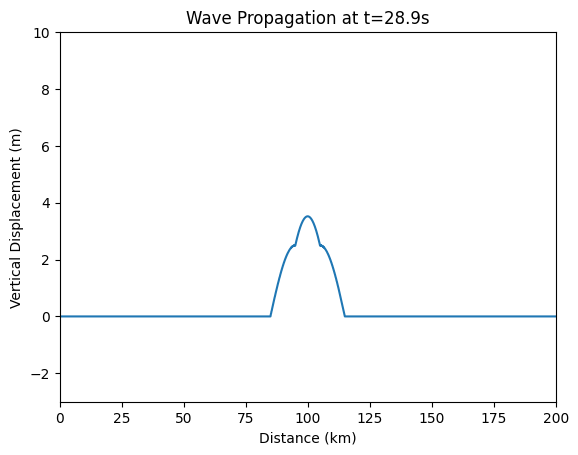

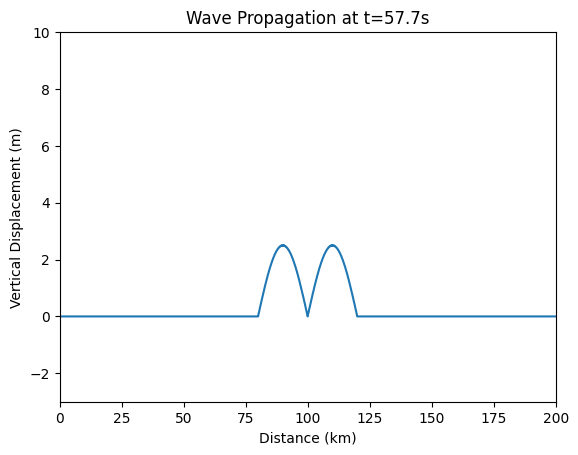

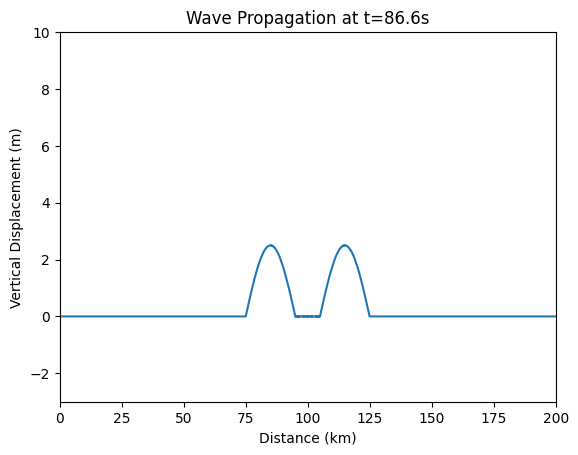

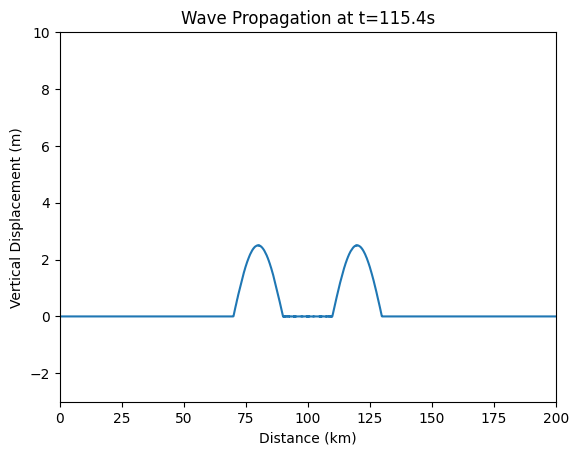

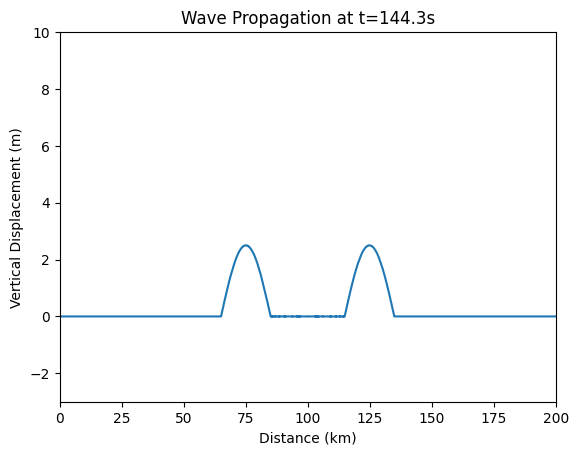

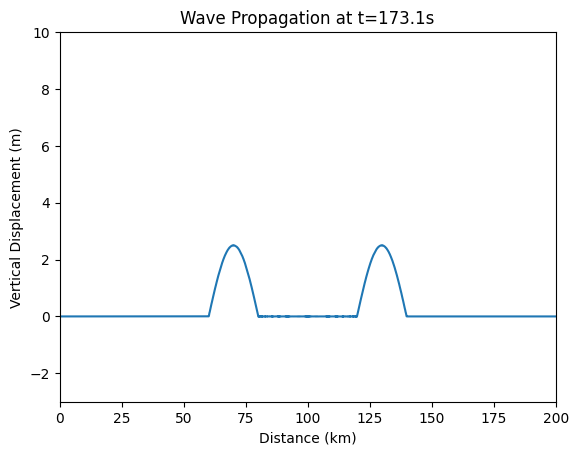

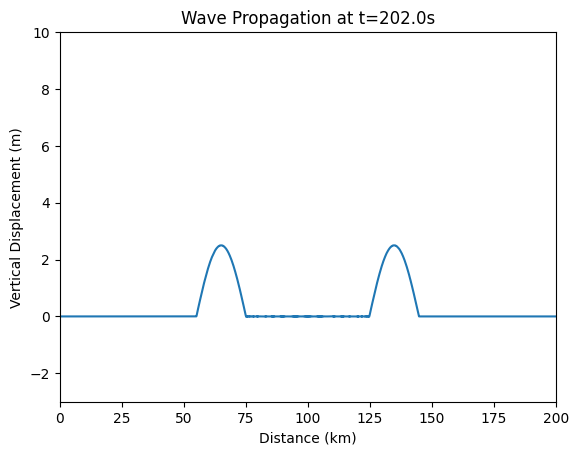

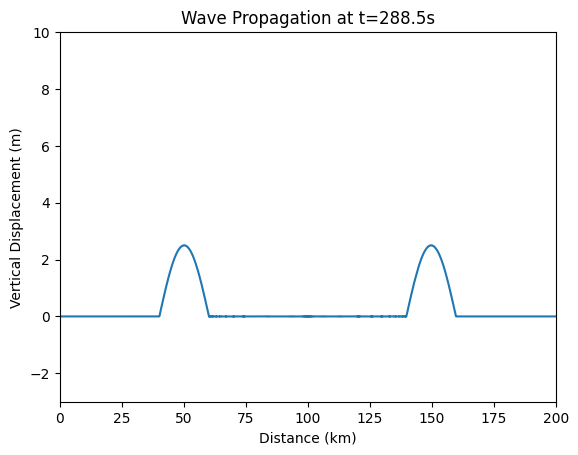

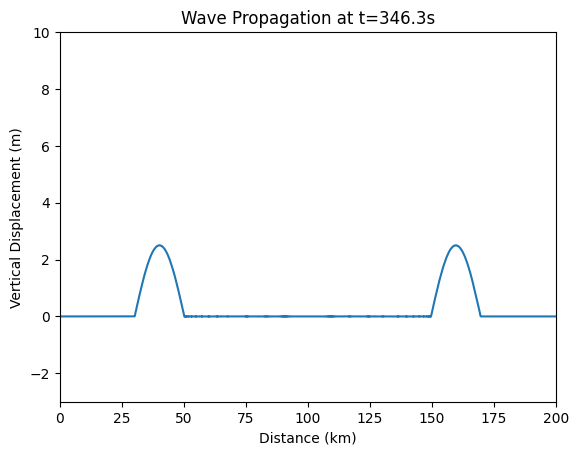

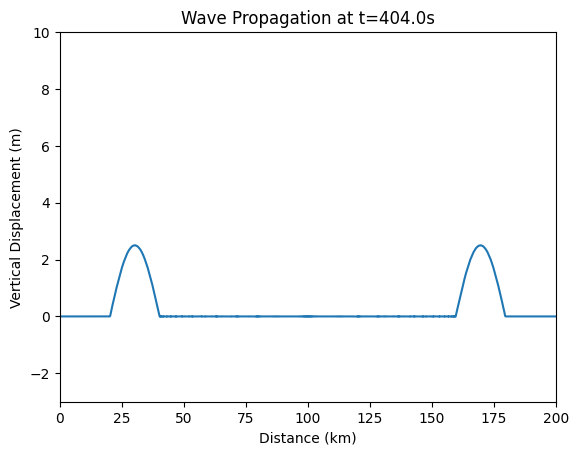

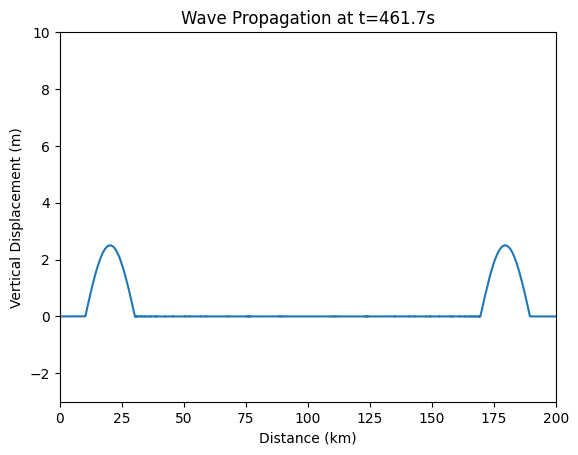

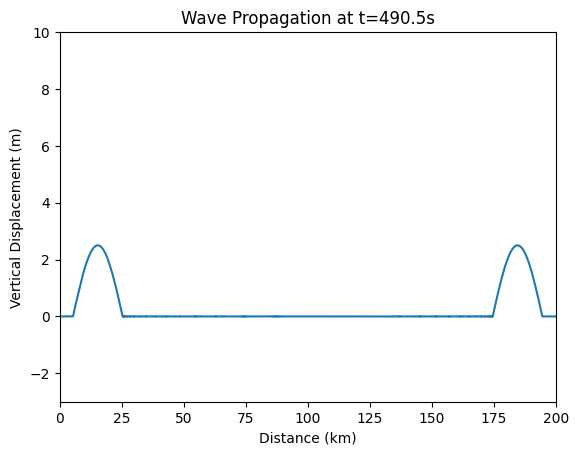

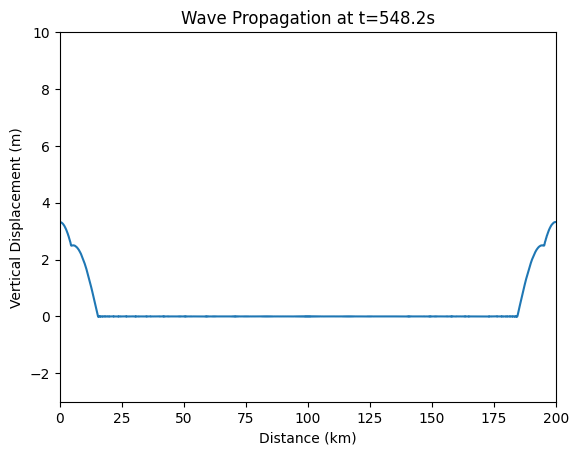

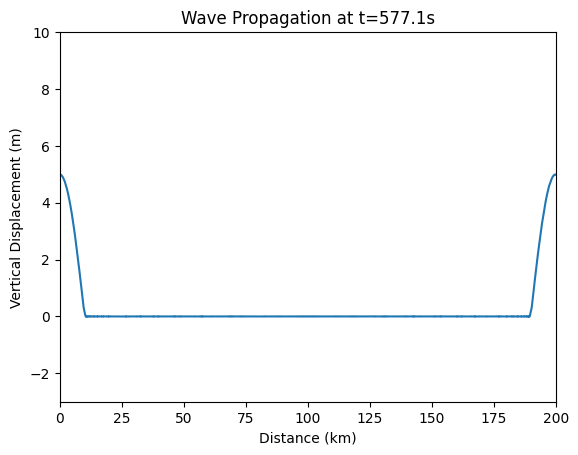

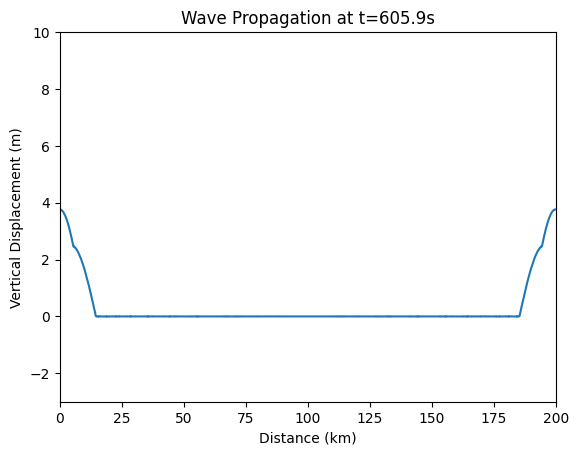

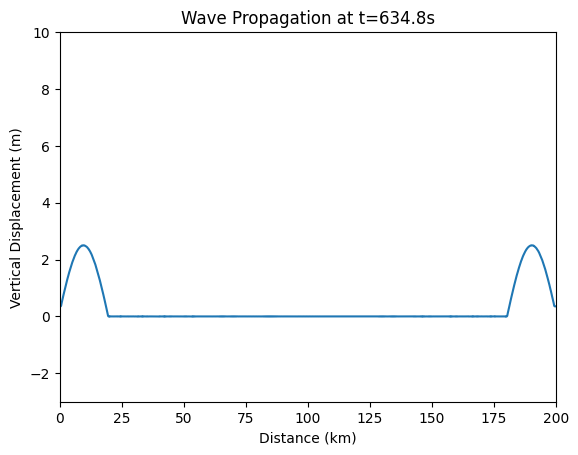

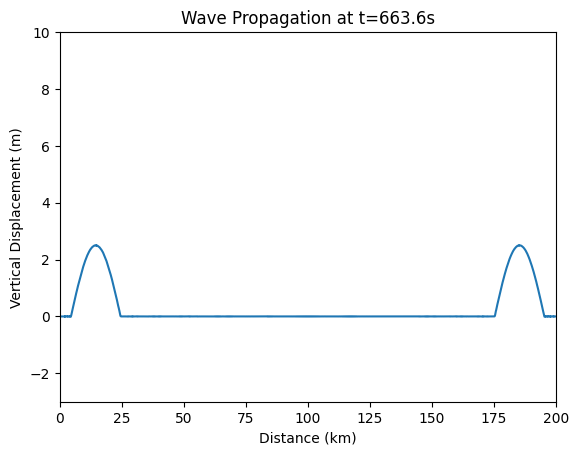

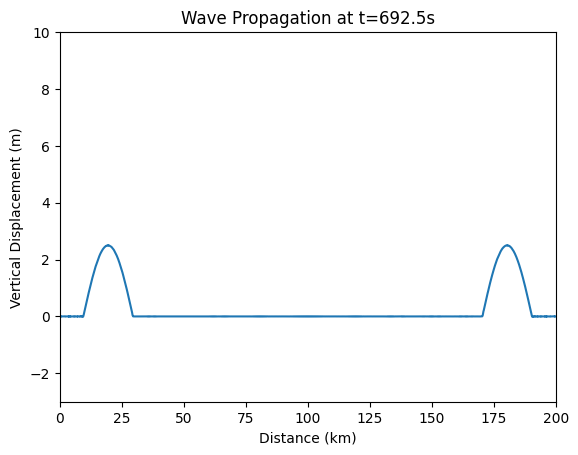

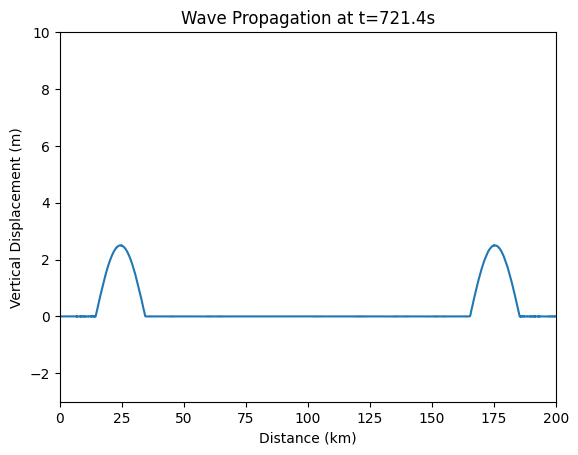

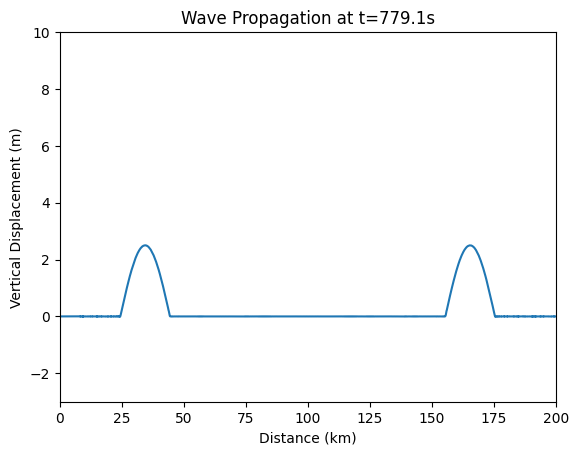

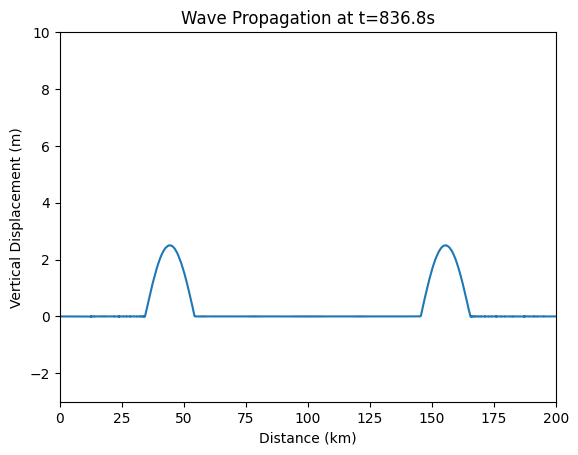

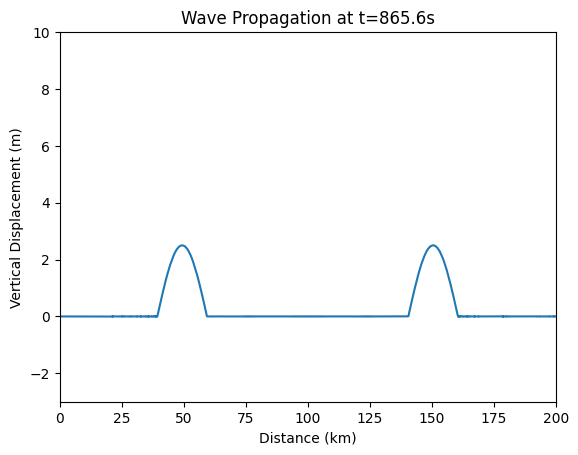

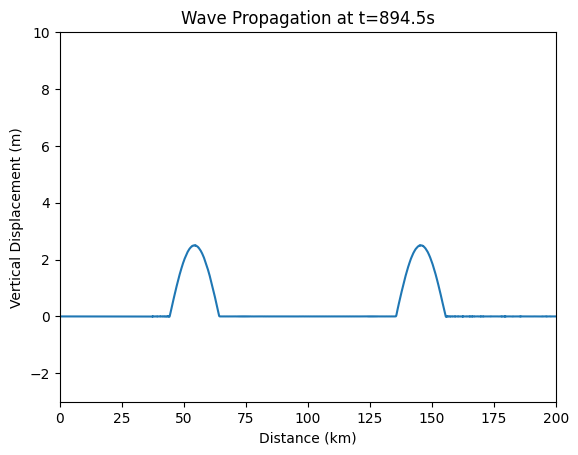

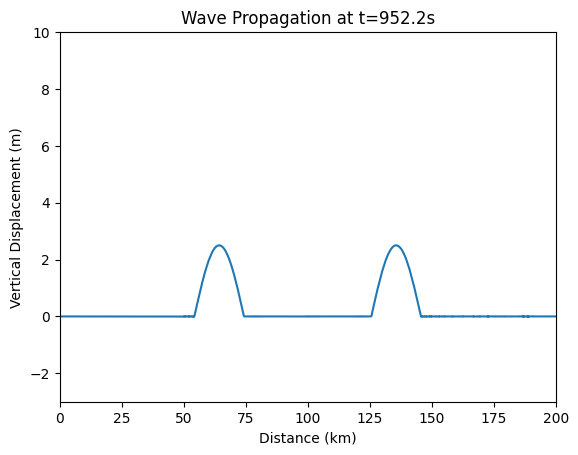

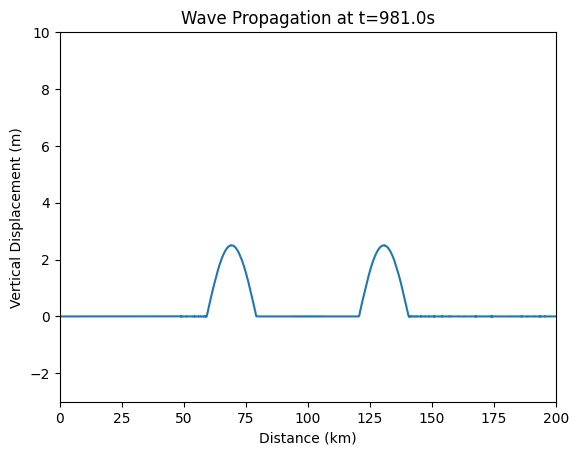

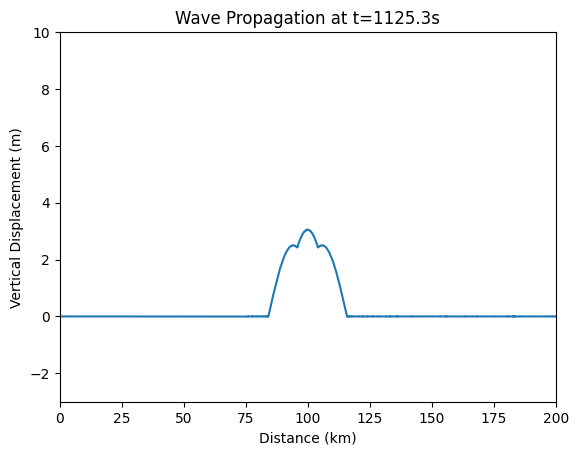

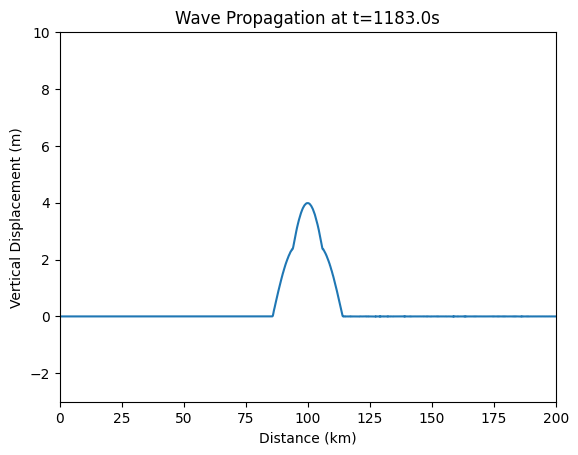

In [4]:
# Initial physcial parameters
g = 9.81 # Acceleration due to gravity
H = 3000 # Water depth (m)
c = np.sqrt(g*H) # Wave speed (m/s)

# Establishing the domain of this model
L = 2e5 # 200 km domain
dx = 100 # 100 m spacing
x = np.arange(0,L+dx,dx)
nx = len(x)

# Time stepping (with CFL Stability Condition lambda<1)
courant = 0.99
dt = courant*dx/c
tf = 1200  # Simulate for 20 minutes to see how the wave travels back
nt = int(tf/dt)

# Build tridiagonal sparse matrix M
main_diag = 2*(1-courant)*np.ones(nx)
off_diag  = courant*np.ones(nx)
M = spdiags([off_diag, main_diag, off_diag],[-1, 0, 1],nx, nx).toarray()

# Neumann BC at boundaries
M[0, 0]=2*(1-courant)
M[-1,-1]=2*(1-courant)

# Create an initial wave matrix
wave_init = np.zeros(nx)

# Sinusoidal wave parameters
wave_height = 5      # amplitude
wave_width = 20000  # total spatial width of the sinusoid (20 km)

# Define sinusoidal initial condition centered in the domain (ChatGPT helped with defining as function of time AND space)
center = L/2
phase = (x - center) * (np.pi / wave_width)

wave_init = np.zeros(nx)
mask = np.abs(x-center) <= wave_width/2
wave_init[mask] = wave_height * np.cos(phase[mask])

# Allocate solution array
wave_all = np.zeros((nx, nt+1))
wave_all[:, 0] = wave_init.copy()
wave_all[:, 1] = wave_init.copy()     # zero initial velocity

# Plot the initial wave
plt.figure()
plt.plot(x/1000,wave_all[:,0])
plt.ylim(-3,10)
plt.xlim(0,L/1000)
plt.xlabel("Distance (km)")
plt.ylabel("Vertical Displacement (m)")
plt.title("Initial Condition at t = 0 s")
plt.show()


# Time stepping/updating the wave and plotting
plt.ion()
for n in range(1, nt):
    wave_all[:, n+1] = M @ wave_all[:, n] - wave_all[:, n-1]
    # Reflective Neumann boundaries
    wave_all[0, n+1]  = wave_all[1, n+1]
    wave_all[-1,n+1]  = wave_all[-2,n+1]

    if n % 50 == 0:
        plt.clf()
        plt.plot(x/1000, wave_all[:, n+1])
        plt.ylim(-3,10)
        plt.xlim(0,L/1000)
        plt.xlabel("Distance (km)")
        plt.ylabel("Vertical Displacement (m)")
        plt.title(f"Wave Propagation at t={n*dt:.1f}s")
        plt.pause(0.01)

plt.ioff()
plt.show()


# Section 4: Results

**Simulations**
We ran 4 different simulations of the toy model, each of which we altered one variable from the initial conditions stated earlier.

**Simulation 1**: Working Toy Model

In the initial run, the wave seems to collapse along the sides then towards the center and create two waves that propagate towards the outside boundaries. Each of the waves are approximately half of the initial water column's height and have a deteriorating rippling effect from front to back. Additionally, there is a consistently changing ripple between the waves as they continue towards the boundary. When the waves hit the reflective boundary, the water pushes against the imaginary boundary, reaching the height of the initial wave, then turning back towards the center. This model showcases the same behavior to that of the instantaneous displacement plot in Kowalik's paper on page 86; however, their figure does not have any distortions as seen in the modeled wave.

Image embeds have a *lot* of characters, so the figure image has been replaced with a request for you to refer to Figure III.1 on page 86 (Kowalik et al., 2012) :D

**Simulations 2 & 3:** Changing the scales

*#2: Finer Domain Spacing:*
*   $dx$ = 50m
*   Changes noticed: There are still a lot of quiet oscillations as the wave begins to move outwards from the center, implying how various factors can affect the shape of the wave. There are more ripples between the waves, and the rippling on both the wave tops and between the waves look oscillate in a more structured manner than the way ocean water moves. These distortions can be resolved with a finer spatial grid (pg. 57) as the finer grid space can better capture and resolve the nonlinear terms that are parameterized in this simpler wave equation.

*#3: Increase Water Depth:*
*   $H$ = 5000m
*   Changes noticed: Given wave propagation is very dependent on water depth, the only factor that altering the water depth impacts is the wave speed. We use the same time period to visualize that the wave travels further over the same amount of time as compared to the previous simulations, as seen how it reflects and returns to the center

**Simulation 4:** Changing rectangular wave to a sinusoidal wave

The wave acted in a similar nature to the rectangular wave in which it collapsed along to sides then the center to create two smaller sinusoidal wave. Having a sinusoidal wave greatly altered how the wave interacted with the domain. There were very few distortions and the waves maintained a smooth shape throughout the simulation, though still behaved similarly to the rectangular wave in its interaction with the reflective boundaries. Additionally, when the waves would meet at the center again, the waves would collide, reform its shape from $t=0$, and essentially repeat its motion.

**Real World Implications**

These models demonstrate in a simplified manner how certain applied forces, such as earthquakes, may generate water columns that evolve into tsunamis. In a more realistic setting, there would obviously not be infinitely tall reflective boundaries that a tsunami bounces off, as that would take an incredible amount of resources to build. Real-world factors may include sea walls of realistic height and rough bathymetry as the wave approaches the coast. In this scenario, the wave would reenact what the models ran, where changes in water depth pushes the water upwards, potentially over the critical point of coastal infrastructure and leading to excess water flooding populated areas. Therefore, this model shows a rough understanding of how coastal communities can prepare for tsunami hazards based on their coast's geography with waves of different timings and amplitudes.

**Potential Improvements**

Given the more simple nature of this equation, introducing more dimensions can help with visualizing how waves are subject to all three dimensions when they spread out. Additionally, nonlinear terms that are approximated in this equation could be more accurately resolved. This would be more computationally expensive, but may better capture the physical processes behind wave propagation.

# Section 5: References :)

Kowalik, Z., (2012). *Introduction to Numerical Modeling of Tsunami Waves* https://www.uaf.edu/cfos/files/research-projects/people/kowalik/book_sum.pdf

Priti Tandel, Hardik Patel, Trushit Patel, Tsunami wave propagation model: A fractional approach, Journal of Ocean Engineering and Science, Volume 7, Issue 6, 2022, Pages 509-520, ISSN 2468-0133, https://doi.org/10.1016/j.joes.2021.10.004.